In [21]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
import keras.backend as K
from keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer, RepeatVector, Add
from keras.layers import Input, BatchNormalization, GaussianNoise, LSTM, Conv1D, MaxPooling1D
from keras.layers import Dropout, Flatten, Bidirectional
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

Attention Layer

In [22]:
import os

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer, and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


# References:
# - https://arxiv.org/pdf/1508.04025.pdf (Luong).
# - https://arxiv.org/pdf/1409.0473.pdf (Bahdanau).
# - https://machinelearningmastery.com/the-bahdanau-attention-mechanism/ (Some more explanation).

class Attention(object if debug_flag else Layer):
    SCORE_LUONG = 'luong'
    SCORE_BAHDANAU = 'bahdanau'

    def __init__(self, units: int = 128, score: str = 'luong', **kwargs):
        super(Attention, self).__init__(**kwargs)
        if score not in {self.SCORE_LUONG, self.SCORE_BAHDANAU}:
            raise ValueError(f'Possible values for score are: [{self.SCORE_LUONG}] and [{self.SCORE_BAHDANAU}].')
        self.units = units
        self.score = score

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            # W in W*h_S.
            if self.score == self.SCORE_LUONG:
                self.luong_w = Dense(input_dim, use_bias=False, name='luong_w')
                # dot : last hidden state H_t and every hidden state H_s.
                self.luong_dot = Dot(axes=[1, 2], name='attention_score')
            else:
                # Dense implements the operation: output = activation(dot(input, kernel) + bias)
                self.bahdanau_v = Dense(1, use_bias=False, name='bahdanau_v')
                self.bahdanau_w1 = Dense(input_dim, use_bias=False, name='bahdanau_w1')
                self.bahdanau_w2 = Dense(input_dim, use_bias=False, name='bahdanau_w2')
                self.bahdanau_repeat = RepeatVector(input_shape[1])
                self.bahdanau_tanh = Activation('tanh', name='bahdanau_tanh')
                self.bahdanau_add = Add()

            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')

            # exp / sum(exp) -> softmax.
            self.softmax_normalizer = Activation('softmax', name='attention_weight')

            # dot : score * every hidden state H_s.
            # dot product. SUM(v1*v2). H_s = every source hidden state.
            self.dot_context = Dot(axes=[1, 1], name='context_vector')

            # [Ct; ht]
            self.concat_c_h = Concatenate(name='attention_output')

            # x -> tanh(w_c(x))
            self.w_c = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras. Supports:
            - Luong's multiplicative style.
            - Bahdanau's additive style.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: philipperemy, felixhao28.
        """
        h_s = inputs
        if debug_flag:
            self.build(h_s.shape)
        h_t = self.h_t(h_s)
        if self.score == self.SCORE_LUONG:
            # Luong's multiplicative style.
            score = self.luong_dot([h_t, self.luong_w(h_s)])
        else:
            # Bahdanau's additive style.
            self.bahdanau_w1(h_s)
            a1 = self.bahdanau_w1(h_t)
            a2 = self.bahdanau_w2(h_s)
            a1 = self.bahdanau_repeat(a1)
            score = self.bahdanau_tanh(self.bahdanau_add([a1, a2]))
            score = self.bahdanau_v(score)
            score = K.squeeze(score, axis=-1)

        alpha_s = self.softmax_normalizer(score)
        context_vector = self.dot_context([h_s, alpha_s])
        a_t = self.w_c(self.concat_c_h([context_vector, h_t]))
        return a_t

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({'units': self.units, 'score': self.score})
        return config

### 一、載入資料

1.1. 載入資料

In [23]:
data = pd.read_csv('/Users/yitsung/Desktop/MasterThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.轉換成EMA+return data

In [24]:
# origi_data #
origi_data = ticker_2330.copy() # 用來之後還原答案的

# ticker_2330['open'] = ticker_2330['open'].diff()
# ticker_2330['high'] = ticker_2330['high'].diff()
# ticker_2330['low'] = ticker_2330['low'].diff()
# ticker_2330['close'] = ticker_2330['close'].diff()

# # EMA diff #
# ticker_2330['EMA9'] = ticker_2330['EMA9'].diff()
# ticker_2330['EMA12'] = ticker_2330['EMA12'].diff()
# ticker_2330['EMA26'] = ticker_2330['EMA26'].diff()

# ticker_2330.replace([float('inf'), -float('inf')], 0, inplace=True) # 不知道為何有些調整過後會變inf, 要拿掉(應該是連兩天的價格都相同)
# ticker_2330 = ticker_2330.dropna().reset_index(drop=True)

ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.3.切Library和Prediction

In [25]:
Library = ticker_2330[ticker_2330['Date'] <= '2023-06-30'] # windows=20, 最後預測到6/30
Prediction = ticker_2330[(ticker_2330['Date'] >= '2023-06-01')&(ticker_2330['Date'] <= '2023-10-31')] # windows=20, 從6/1預測7/3開始
Prediction.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
681,2023-10-25,544.0,551.0,544.0,544.0,17137.0,-99.0,-2573.0,651.0,-142.0,1185.0,3.9095,544.649068,543.673118,541.716547,1.956572,0.734048,91.909547
682,2023-10-26,530.0,535.0,530.0,531.0,31683.0,487.0,-10712.0,-35173.0,-1744.0,-10261.0,6.9033,541.919255,541.723408,540.922728,0.800679,0.747374,85.178131
683,2023-10-27,534.0,536.0,532.0,533.0,17051.0,17.0,-5262.0,1478.0,-73.0,-1739.0,4.1968,540.135404,540.381345,540.335860,0.045485,0.606996,78.927028
684,2023-10-30,531.0,534.0,528.0,532.0,23299.0,265.0,-11811.0,487.0,378.0,-5803.0,5.6532,538.508323,539.091907,539.718389,-0.626481,0.360301,72.836426
685,2023-10-31,535.0,535.0,527.0,529.0,28073.0,113.0,-9363.0,495.0,-358.0,-5392.0,5.4314,536.606658,537.539306,538.924434,-1.385128,0.011215,63.359478


### 二、資料分拆

2.1.MinMax

In [26]:
def make_data_minmax(Library, Prediction, target):

    # 將target放至最後面 #
    Library_target_col = Library.pop(f'{target}')
    Library[f'{target}'] = Library_target_col
    Prediction_target_col = Prediction.pop(f'{target}')
    Prediction[f'{target}'] = Prediction_target_col

    # MinMax #
    scaler_X = MinMaxScaler()
    feature_to_standardize = Library.columns.to_list()[1 : -1]
    Library[feature_to_standardize] = scaler_X.fit_transform(Library[feature_to_standardize])
    Prediction[feature_to_standardize] = scaler_X.fit_transform(Prediction[feature_to_standardize])

    scaler_y = MinMaxScaler()
    Lib_ans = Library.iloc[:, -1].values.reshape(-1, 1)
    Library.iloc[:, -1] = scaler_y.fit_transform(Lib_ans)
    Pred_ans = Prediction.iloc[:, -1].values.reshape(-1, 1)
    Prediction.iloc[:, -1] = scaler_y.fit_transform(Pred_ans)

    return Library, Prediction, scaler_y

In [27]:
### 切train和validation ###
train_Library = Library[: int((len(Library) * 0.8))]
valid_Library = Library[int((len(Library) * 0.8)): ]
train_Library, valid_Library, scaler_y = make_data_minmax(Library=train_Library, Prediction=valid_Library, target='close')

### 切完整data ###
Library, Prediction, scaler_y = make_data_minmax(Library=Library, Prediction=Prediction, target='close')

2.2.製作data

In [28]:
def create_dataset(data, windows, Tp, target):

    data = data.drop(columns=['Date'])
    num_of_target_col = data.columns.to_list().index(f'{target}')

    X, y = [], []
    for i in range(len(data) - windows - (Tp - 1)): # 預測t+1:-0, 預測t+2:-1 ...
        X.append(data.iloc[i:(i + windows)])
        y.append(data.iloc[i + windows + (Tp - 1), num_of_target_col])  # 預測t+1:+0, 預測t+2:+1 ... # 後面那個是target的索引

    X, y = np.array(X), np.array(y)
        
    return X, y

In [29]:
train_X, train_y = create_dataset(data=train_Library, windows=20, Tp=1, target='close')
valid_X, valid_y = create_dataset(data=valid_Library, windows=20, Tp=1, target='close')
X, y = create_dataset(data=Library, windows=20, Tp=1, target='close')
pred_X, pred_y = create_dataset(data=Prediction, windows=20, Tp=1, target='close')

2.2.5. Flatten (MLP only)

In [30]:
def make_X_flatten(X):
    X_flatten = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))

    return X_flatten

In [31]:
# train_X = make_X_flatten(train_X)
# valid_X = make_X_flatten(valid_X)
# pred_X = make_X_flatten(pred_X)

### 三、建模分析

3.1. 建構LSTM-AM model

In [32]:
def create_lstm_am(hp, num_columns):

    ################## Parameters ######################
    units_1 = hp.Int(name="units_1", min_value=16, max_value=128, step=16)
    units_2 = hp.Int(name="units_2", min_value=16, max_value=128, step=16)
    units_3 = hp.Int(name="units_3", min_value=16, max_value=128, step=16)
    units_4 = hp.Int(name="units_4", min_value=16, max_value=128, step=16)

    dropout_1 = hp.Choice("dropout_1", [0.0, 0.2, 0.5, 0.8])

    lr = hp.Choice('lr',[1e-2, 1e-3, 1e-5])
    ####################################################

    inp = Input(shape = (num_columns[1], num_columns[2]))

    lstm = LSTM(units_1, return_sequences=True)(inp)
    lstm = LSTM(units_2, return_sequences=True)(lstm)
    lstm = LSTM(units_2, return_sequences=True)(lstm)
    lstm = LSTM(units_2, return_sequences=True)(lstm)
    attention = Attention(units_3)(lstm)

    x = Dense(units_4)(attention)
    x = Dropout(dropout_1)(x)

    out = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics='mean_squared_error')

    
    return model

In [33]:
TUNNING = True

if TUNNING:
    model_fn = lambda hp: create_lstm_am(hp, num_columns=train_X.shape)
    tuner = kt.BayesianOptimization(model_fn,
                                    objective='val_mean_squared_error',
                                    max_trials=1,
                                    executions_per_trial=1,
                                    directory="LSTM_AM_price_kt",
                                    overwrite=True,
                                    seed=87)
    
    es = EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=10,
                       baseline=None, restore_best_weights=True, verbose=0)
    
    tuner.search(train_X, train_y, validation_data=(valid_X, valid_y), epochs=100, 
                 batch_size=16, callbacks=[es], verbose=1)
    
    LSTM_AM_model = tuner.get_best_models()[0]

Trial 1 Complete [00h 00m 25s]
val_mean_squared_error: 0.01836078241467476

Best val_mean_squared_error So Far: 0.01836078241467476
Total elapsed time: 00h 00m 25s


In [34]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'units_1': 32, 'units_2': 64, 'units_3': 16, 'units_4': 32, 'dropout_1': 0.0, 'lr': 0.001}


3.3.完整訓練cnn-lstm

In [35]:
def create_lstm_am(num_columns, hidden_units, dropout_rates, lr):

    inp = Input(shape = (num_columns[1], num_columns[2]))

    lstm = LSTM(hidden_units[0], return_sequences=True)(inp)
    lstm = LSTM(hidden_units[1], return_sequences=True)(lstm)
    lstm = LSTM(hidden_units[1], return_sequences=True)(lstm)
    lstm = LSTM(hidden_units[1], return_sequences=True)(lstm)
    attention = Attention(hidden_units[2])(lstm)

    x = Dense(hidden_units[3])(attention)
    x = Dropout(dropout_rates[0])(x)

    out = Dense(1)(x)

    model = tf.keras.models.Model(inputs=inp, outputs=out)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics='mean_squared_error')

    return model

params = {'num_columns': train_X.shape,
          'hidden_units': [128, 256, 128, 64],
          'dropout_rates': [0.0, 0.2, 0.8],
          'lr': 0.001}

In [36]:
def train_LSTM_AM(batch_size, X, y):

    LSTM_AM_path = f'LSTM_AM.hdf5'

    model = create_lstm_am(**params)
    ckp = ModelCheckpoint(LSTM_AM_path, monitor='val_mean_squared_error', verbose=0, 
                        save_best_only=True, save_weights_only=True)
    es = EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=10, 
                       baseline=None, restore_best_weights=True, verbose=0)
    history = model.fit(X, y, validation_data=(valid_X, valid_y),
                        # sample_weight = sw[tr], 
                        epochs=100, batch_size=batch_size, callbacks=[ckp, es], verbose=1)

    hist = pd.DataFrame(history.history)
    score = hist['val_mean_squared_error'].min()
    print(f'MSE:', score)

    return history, model

history, model = train_LSTM_AM(batch_size=16, X=train_X, y=train_y)

Epoch 1/100


2024-03-17 23:25:58.572845: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


29/29 [==============================] - ETA: 0s - loss: 0.0722 - mean_squared_error: 0.0722

2024-03-17 23:26:01.381215: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


29/29 [==============================] - 5s 82ms/step - loss: 0.0722 - mean_squared_error: 0.0722 - val_loss: 0.0431 - val_mean_squared_error: 0.0431
Epoch 2/100
29/29 [==============================] - 1s 35ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0310 - val_mean_squared_error: 0.0310
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 5/100
29/29 [==============================] - 1s 32ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 6/100
29/29 [==============================] - 1s 30ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0217 - val_mean_squared_error: 0.0217
Epoch 7/100
29/29 [=====================

3/3 [==============================] - 0s 21ms/step


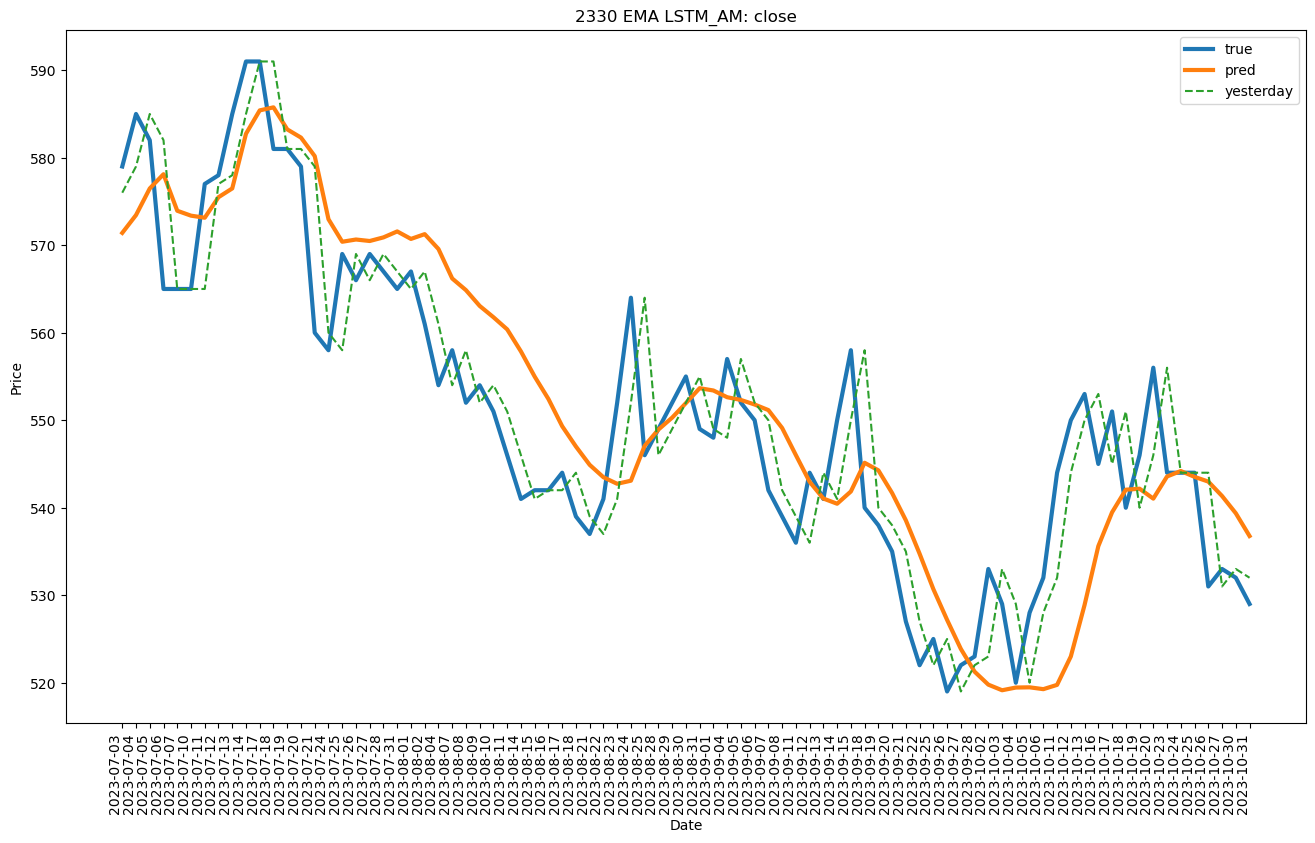

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,571.408447,576.0
1,2023-07-04,585.0,573.445190,579.0
2,2023-07-05,582.0,576.486206,585.0
3,2023-07-06,565.0,578.116516,582.0
4,2023-07-07,565.0,573.937622,565.0
...,...,...,...,...
78,2023-10-25,544.0,543.525635,544.0
79,2023-10-26,531.0,542.984619,544.0
80,2023-10-27,533.0,541.341187,531.0
81,2023-10-30,532.0,539.368896,533.0


In [38]:
def test_model(pred_X, model):

    ### 預測 ###
    y_pred = model.predict(pred_X)
    y_pred = y_pred.reshape(-1,1) # reshape成可以還原的格式
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = pd.Series(y_pred.reshape(-1)) # 變成series格式化成相同index方便畫圖

    # 取得前一日資料
    yesterday = origi_data[(origi_data['Date']>='2023-06-30') & (origi_data['Date']<'2023-10-31')].reset_index(drop=True)
    # 取得今日資料
    Today = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index(drop=True)
    # Date
    Date = origi_data[(origi_data['Date']>='2023-07-01') & (origi_data['Date']<'2023-11-01')].reset_index()

    # 製作還原預測資料
    LSTM_AM_result = pd.DataFrame(yesterday['close'])
    LSTM_AM_result = LSTM_AM_result.rename(columns={'close': 'Yesterday'})

    LSTM_AM_result['Predictions'] = y_pred # origin
    # LSTM_AM_result['Predictions'] = LSTM_AM_result['Yesterday'] + y_pred # diff

    LSTM_AM_result['Observations'] = Today['close']   
    LSTM_AM_result['Date'] = Date['Date']

    LSTM_AM = LSTM_AM_result[['Date', 'Observations', 'Predictions', 'Yesterday']]

    # 繪圖
    plt.figure(figsize=(16, 9))
    plt.plot(LSTM_AM['Date'], LSTM_AM[f'Observations'], linewidth=3, label='true')
    plt.plot(LSTM_AM['Date'], LSTM_AM[f'Predictions'], linewidth=3, label='pred')
    plt.plot(LSTM_AM['Date'], LSTM_AM[f'Yesterday'], linestyle='--', label='yesterday')

    plt.xlabel('Date')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Price')
    plt.title(f'2330 EMA LSTM_AM: close')
    plt.legend()
    plt.show()

    return LSTM_AM

LSTM_AM = test_model(pred_X=pred_X, model=model)
LSTM_AM